In [7]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt

from src.encoders import EmbeddingEncoder
from src.decoders import BinomialDecoder
from src.priors import PriorMlp
from src.seq_vae import SeqVae
from src.train import *


from plotting_utils import *
from src.utils import *


In [8]:
def get_training_data(y, train_ratio=0.8, batch_size=128, norm=False):

    K = y.shape[0]

    "let's get the reference data"
    N_train = int(np.ceil(train_ratio * K))
    y_train = y[:N_train]

    if norm:
        y_train = normalize(y_train)

    train_dataloader = SeqDataLoader((y_train,), batch_size=batch_size)
    return train_dataloader

In [9]:
# load data
data = torch.load('../data/low_d/vdp/noisy_vanderpol_binomial_dt=0.1.pt')

# arbitrarily assign data for training vae and alignment
y = data[0]['y']
w = data[2]['y']

## Train VAE on source data $y_{1:T}$

In [65]:
d_latent = 2
d_hidden = 64
d_embed = 64

d_observation = y.shape[2]

device = 'cpu'
if torch.cuda.is_available:
    device = 'cuda'

"let's define our vae"
encoder = EmbeddingEncoder(d_observation, d_latent, d_hidden, d_embed=d_embed, device=device)
prior = PriorMlp(d_latent, device=device)
decoder = BinomialDecoder(d_latent, d_observation, device=device)

vae = SeqVae(prior, encoder, decoder, device=device)

# get dataloader for training
train_dataloader = get_training_data(y, train_ratio=0.5)

"let's train our vae"
ref_vae, losses_vae = vae_training(vae, train_dataloader, n_epochs=1_000, lr=1e-3, beta=torch.ones(1000))


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.89it/s]


## Visualuze Dynamics Learnt from $y_{1:T}$

100%|██████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 4347.96it/s]


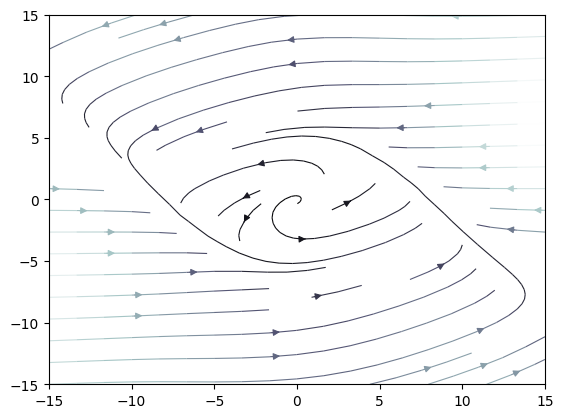

In [68]:
x_min, x_max = -15, 15
y_min, y_max = -15, 15

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
dynamics = lambda x:vae.prior.compute_param(x)[0]

xt, yt, vel_x, vel_y, speed = compute_vector_field(dynamics, x_min, x_max, y_min, y_max, device=device)
plt.streamplot(xt, yt, vel_x.numpy(), vel_y.numpy(), color=speed.numpy(), cmap='bone', linewidth=0.8, density=0.6)


In [69]:
for param in ref_vae.parameters():
    param.requires_grad = False

## Train alignment function from $w_{1:T}$

In [83]:
from src.align import *

d_observation_new = w.shape[2]

# likelihood function for w
decoder = BinomialDecoder(d_latent, d_observation_new, device=device)

# get dataloader for training
train_dataloader = get_training_data(w, train_ratio=0.1)

# define module for aligning with k-step loss
align = Align(d_observation_new, d_embed, decoder, k_step=10, linear_flag=False, device=device)
res_align, losses_align = alignment_training(ref_vae, align, train_dataloader, n_epochs=1_000,
                                         lr=1e-3)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.15it/s]


## Sample latent trajectories from reference VAE after aligning $w_{1:T}$

In [84]:
N_train = int(0.8 * w.shape[2])

w_test = w[N_train:].to(device)

with torch.no_grad():
    w_align = align.g(w_test)
    x_samples = ref_vae.encoder.sample(w_align)[0]

## Plot latent trajectories from $w_{1:T}$ on dynamics from pre-trained model

100%|██████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 4295.34it/s]


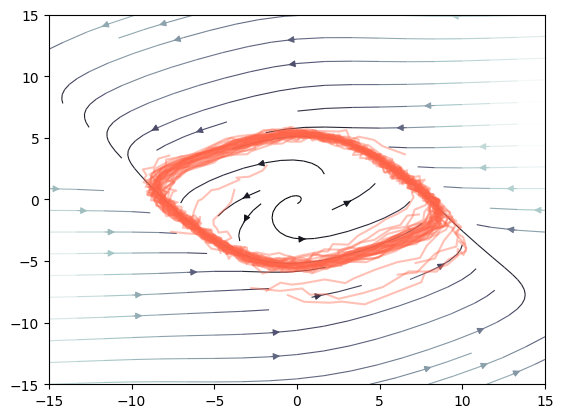

In [85]:
x_min, x_max = -15, 15
y_min, y_max = -15, 15

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()

dynamics = lambda x:vae.prior.compute_param(x)[0]
xt, yt, vel_x, vel_y, speed = compute_vector_field(dynamics, x_min, x_max, y_min, y_max, device=device)
plt.streamplot(xt, yt, vel_x.numpy(), vel_y.numpy(), color=speed.numpy(), cmap='bone', linewidth=0.8, density=0.6)

plt.plot(x_samples[:10, :, 0].T.to('cpu'), x_samples[:10, :, 1].T.to('cpu'), color='tomato', alpha=0.4)

plt.show()